In [71]:
import logging
import pathlib
import shutil
import sys
logging.basicConfig()
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tdc import Evaluator
import numpy as np

sys.path.append('..')
from sbap.sdf import ChemblSdfReader
from sbap.featurizers.prolif_smina import SminaDockingPersistenceHandler, SminaConfig, DockedProlifFingerprintFeaturizer, SminaDockingScoreFeaturizer

In [72]:
sdf_file = pathlib.Path("../molecules/CYP2C9_IC50_CHEMBL_data.sdf")
protein_pdb_file = pathlib.Path("../molecules/4nz2_CYP2C9_cleaned.pdb")
docked_ligands_target_directory = pathlib.Path("../molecules/CYP2C9")

fingerprint_featurizer = DockedProlifFingerprintFeaturizer.create(
    logging_level=logging.INFO,
)
docking_score_featurizer = SminaDockingScoreFeaturizer(logging.INFO)

In [73]:
fingerprint_featurizer.fit(protein_pdb_file, docked_ligands_target_directory)

  0%|          | 0/5284 [00:00<?, ?it/s]

In [74]:
X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
X.shape

  0%|          | 0/5284 [00:00<?, ?it/s]

INFO:ProlifInteractionFingerprintGenerator:Receptor interactions found: Index(['PHE69.A Hydrophobic', 'PHE69.A CustomVdWContact',
       'GLY98.A CustomVdWContact', 'ILE99.A CustomVdWContact',
       'PHE100.A Hydrophobic', 'PHE100.A HBDonor', 'PHE100.A CationPi',
       'PHE100.A CustomVdWContact', 'LEU102.A Hydrophobic', 'LEU102.A HBDonor',
       ...
       'PHE476.A CationPi', 'PHE476.A CustomVdWContact',
       'ALA477.A CustomVdWContact', 'SER478.A CustomVdWContact',
       'VAL479.A Hydrophobic', 'VAL479.A CustomVdWContact',
       'PRO480.A CustomVdWContact', 'HEM501.A Hydrophobic', 'HEM501.A HBDonor',
       'HEM501.A CustomVdWContact'],
      dtype='object', length=129)


(5284, 130)

  0%|          | 0/5284 [00:00<?, ?it/s]

INFO:ProlifInteractionFingerprintGenerator:Receptor interactions found: Index(['PHE69.A Hydrophobic', 'PHE69.A CustomVdWContact',
       'GLY98.A CustomVdWContact', 'ILE99.A CustomVdWContact',
       'PHE100.A Hydrophobic', 'PHE100.A HBDonor', 'PHE100.A CationPi',
       'PHE100.A CustomVdWContact', 'LEU102.A Hydrophobic', 'LEU102.A HBDonor',
       ...
       'PHE476.A CationPi', 'PHE476.A CustomVdWContact',
       'ALA477.A CustomVdWContact', 'SER478.A CustomVdWContact',
       'VAL479.A Hydrophobic', 'VAL479.A CustomVdWContact',
       'PRO480.A CustomVdWContact', 'HEM501.A Hydrophobic', 'HEM501.A HBDonor',
       'HEM501.A CustomVdWContact'],
      dtype='object', length=129)


[44000.   39810.72 10000.   ... 10000.   10700.   50000.  ]
[4.6434526 4.6       4.        ... 4.        4.0293837 4.69897  ]


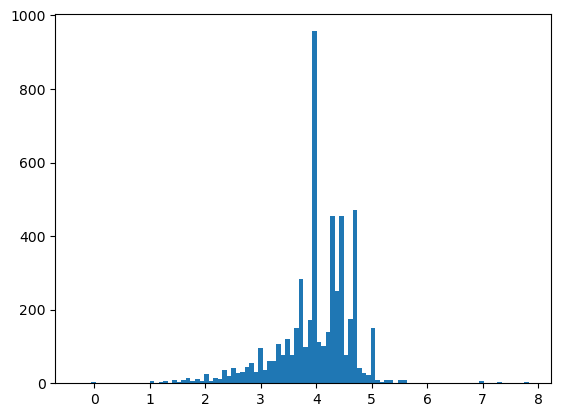

In [69]:
X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
X.shape
dataset_siz = X.shape[0]
y = np.array(y, dtype='f')
print(y)
log_y = np.log10(y)
print(log_y)
plt.hist(log_y, bins=100)
plt.show()
y = log_y

Czy liczba zapalonych bitów fingerprintu koreluje z docking score? Chyba tak

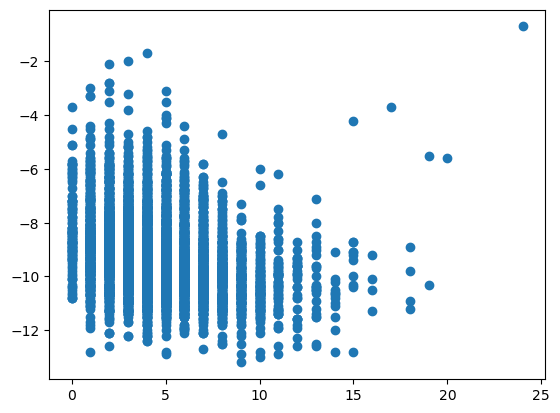

In [76]:
good_indices = np.argwhere(X[:, 0] < 0)
A = np.sum(X[:, 1:], axis=1)
plt.scatter(A[good_indices], X[good_indices, 0])
plt.show()

TODO: 
- sparsify this, somehow
- take less points with score such as 10000

In [8]:
print(np.sum(X[:, 1:], axis=1))

[1. 5. 3. ... 7. 4. 4.]


In [61]:
CUTOFF_THRESHOLD = 5

sums = np.sum(X, axis=0)
good_idces = np.argwhere(sums > CUTOFF_THRESHOLD).flatten()
print(good_idces)
# X = X[:, good_idces]
print(f'now every input vector has {X.shape[1]} bits and on average {np.sum(X[:, 1:]) / dataset_siz} of them is a 1')
print(f'example numbers of 1-bits: {np.sum(X, axis=1)[:20]}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [15]:
def test_model(model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(x_train, y_train)

    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


on train set: RMSE, MAE, R2 = 0.3392631866222848, 0.2371570475064539, 0.7863924820850208
on test set: RMSE, MAE, R2 = 0.7282999589306789, 0.5287619801611975, -0.04472403802173286


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


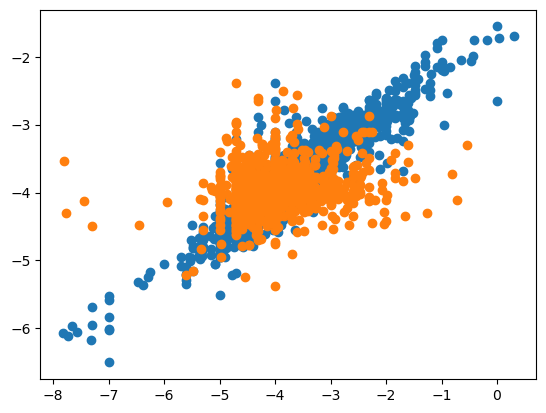

In [48]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

model = RandomForestRegressor(n_estimators=300, min_samples_split=3, verbose=1)
# model = RandomForestRegressor()
test_model(model)

on train set: RMSE, MAE, R2 = 0.5319904369616169, 0.3647642886144428, 0.4801354020909838
on test set: RMSE, MAE, R2 = 0.8616438893591039, 0.6230713334972608, -0.5272425227418993


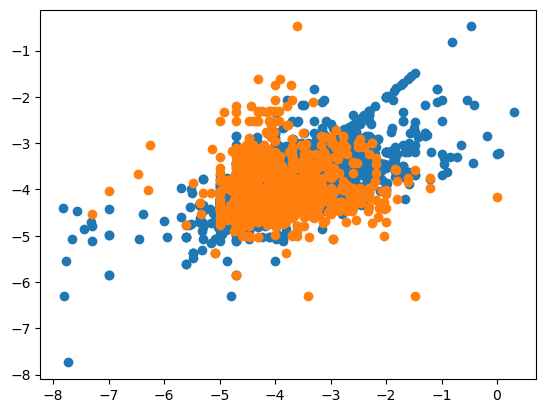

In [46]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tr = DecisionTreeRegressor(min_samples_split=15)
test_model(tr)

on train set: RMSE, MAE, R2 = 0.1614172675033402, 0.03750080726016351, 0.9494441997683924
on test set: RMSE, MAE, R2 = 0.7969499052442499, 0.5522325292596018, -0.05518878136424088


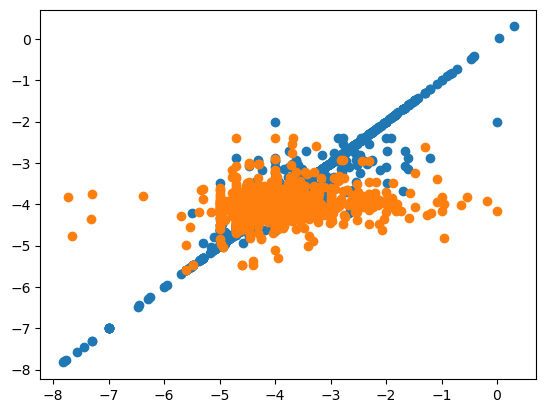

on train set: RMSE, MAE, R2 = 0.1558343602059885, 0.03484136318670824, 0.9543286539161596
on test set: RMSE, MAE, R2 = 0.7605126946211754, 0.542085043424603, -0.07805483689351189


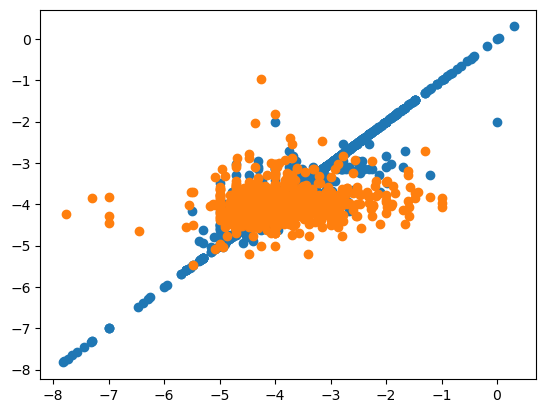

on train set: RMSE, MAE, R2 = 0.16110026186186988, 0.03848630265100607, 0.9502011491626181
on test set: RMSE, MAE, R2 = 0.7735017186684773, 0.5511057175243769, -0.033538203772538244


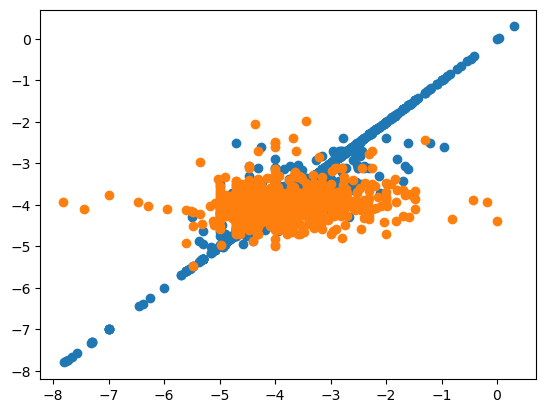

on train set: RMSE, MAE, R2 = 0.16591597956577775, 0.03681636711050966, 0.9489869319766062
on test set: RMSE, MAE, R2 = 0.7316856287714066, 0.5314302018200423, -0.061585617823577854


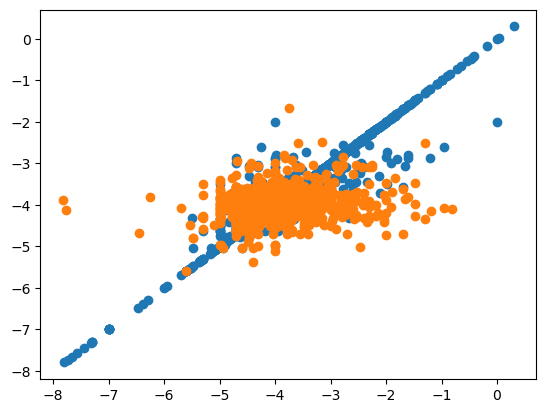

on train set: RMSE, MAE, R2 = 0.15667301922027577, 0.036698936706866865, 0.9540935067720082
on test set: RMSE, MAE, R2 = 0.7412654834172726, 0.5247321354798532, -0.04684729795292086


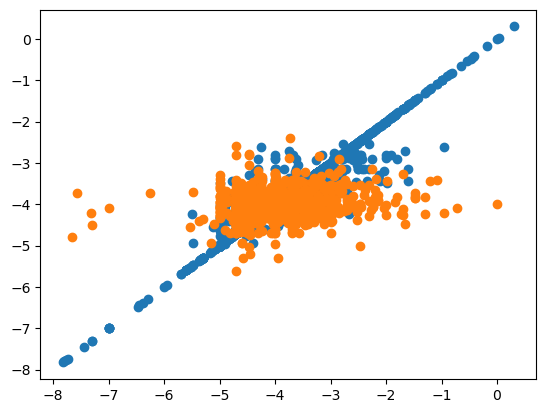

In [49]:
from sklearn.neighbors import KNeighborsRegressor

for alpha in [0.1, 0.5, 1.0, 2.0, 5.0]:
    y_alpha = alpha * y
    x_train, x_test, y_train, y_test = train_test_split(X, y_alpha, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='l1')
    test_model(model)

## Binary classification for a change

In [57]:
high_pic50 = np.argwhere(y > -4.0).flatten()
yb = np.zeros(y.shape)
yb[high_pic50] = 1.0
yb = np.array(yb, dtype='i')
print(yb)
print(sum(yb))

[0 0 0 ... 0 0 0]
1899


In [51]:
# Yeah, I'm super lazy

rmse = Evaluator(name = 'Accuracy')
mae = Evaluator(name = 'Precision')
r_squared = Evaluator(name = 'Recall')

def test_classification_model(model):
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)
    model.fit(xb_train, yb_train)

    predictions = model.predict(xb_train)  
    print(predictions[:40])
    print(yb_train[:40])
    rmse_score = rmse(yb_train, predictions)
    mae_score = mae(yb_train, predictions)
    r2_score = r_squared(yb_train, predictions)
    print(f'on train set: Accuracy, Precision, Recall = {rmse_score}, {mae_score}, {r2_score}')

    predictions = model.predict(xb_test) 
    print(predictions[:36])
    print(yb_test[:36])
    rmse_score = rmse(yb_test, predictions)
    mae_score = mae(yb_test, predictions)
    r2_score = r_squared(yb_test, predictions)
    print(f'on test set: Accuracy, Precision, Recall = {rmse_score}, {mae_score}, {r2_score}')

In [52]:
from sklearn.svm import SVC

model = SVC()
test_classification_model(model)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0]
on train set: Accuracy, Precision, Recall = 0.6593591905564924, 0.0, 0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1
 0 1 0]
on test set: Accuracy, Precision, Recall = 0.7181208053691275, 0.0, 0.0


In [76]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(80, 50, 30, 10), alpha=1.5)
test_classification_model(model)

[1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0]
[1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0
 0 0 1]
on train set: Accuracy, Precision, Recall = 0.9072512647554806, 0.9559748427672956, 0.76
[0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0
 0 0 0]
on test set: Accuracy, Precision, Recall = 0.6711409395973155, 0.44680851063829785, 0.4772727272727273


In [92]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_leaf=9)
test_classification_model(model)

[0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1
 0 0 0]
on train set: Accuracy, Precision, Recall = 0.7521079258010118, 0.7175572519083969, 0.46078431372549017
[0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 1 0]
[1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1]
on test set: Accuracy, Precision, Recall = 0.6577181208053692, 0.36585365853658536, 0.375


In [102]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
test_classification_model(model)

[0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 0]
[0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0]
on train set: Accuracy, Precision, Recall = 0.9966273187183811, 0.9946808510638298, 0.9946808510638298
[0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0]
[0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1
 0 1 0]
on test set: Accuracy, Precision, Recall = 0.6375838926174496, 0.5263157894736842, 0.35714285714285715


### A stupid attempt to transform y further (TODO)

  0%|          | 0/5284 [00:00<?, ?it/s]

INFO:ProlifInteractionFingerprintGenerator:Receptor interactions found: Index(['PHE69.A Hydrophobic', 'PHE69.A CustomVdWContact',
       'GLY98.A CustomVdWContact', 'ILE99.A CustomVdWContact',
       'PHE100.A Hydrophobic', 'PHE100.A HBDonor', 'PHE100.A CationPi',
       'PHE100.A CustomVdWContact', 'LEU102.A Hydrophobic', 'LEU102.A HBDonor',
       ...
       'PHE476.A CationPi', 'PHE476.A CustomVdWContact',
       'ALA477.A CustomVdWContact', 'SER478.A CustomVdWContact',
       'VAL479.A Hydrophobic', 'VAL479.A CustomVdWContact',
       'PRO480.A CustomVdWContact', 'HEM501.A Hydrophobic', 'HEM501.A HBDonor',
       'HEM501.A CustomVdWContact'],
      dtype='object', length=129)


[44000.   39810.72 10000.   ... 10000.   10700.   50000.  ]


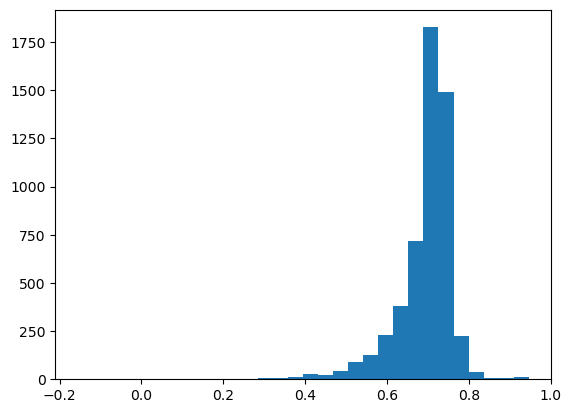

In [62]:
X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
dataset_siz = X.shape[0]-
y = np.array(y, dtype='f')
print(y)
log_y = np.sqrt(np.log10(y) -4.0)
plt.hist(log_y, bins=30)
plt.show()